In [106]:
from imp import reload
import os
import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [195]:
# load a test image
test_img_file = './test_images/test6.jpg'
test_img_rgb = cv2.cvtColor(cv2.imread(test_img_file), cv2.COLOR_BGR2RGB)

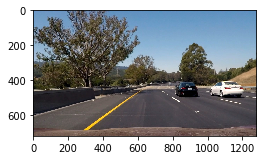

In [196]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
ax1.imshow(test_img_rgb)
plt.show()

### Draw Sliding Windows
- The Red rectangle in each image below is the final window. 

In [1]:
from utils import utils; reload(utils)

roi_scale_list = [
    (350, 450, 1), 
    (400, 600, 1.5), 
    (500, 700, 2.5)
]

plt.figure(figsize=(16, 18))
for n_subplot, (y_start, y_stop, scale) in enumerate(roi_scale_list, start=1):
    plt.subplot(1, 3, n_subplot)
    plt.imshow(utils.draw_sliding_windows(img, y_start, y_stop, scale))
    plt.title('Scale {}'.format(str(n_subplot)))
    plt.xticks([])
    plt.yticks([])
plt.show()

NameError: name 'reload' is not defined

In [229]:
from sklearn.externals import joblib

scaler = joblib.load('./classifiers/standard_scaler.pkl')
clf = joblib.load('./classifiers/linear_svm.pkl')

In [298]:
y_start = 400
y_stop = 500
scale = 1
orientations = 9
convert_to = cv2.COLOR_RGB2YCR_CB
color_space = 'YCrCb'
pix_per_cell = 8
pixels_per_cell = (8, 8)
cell_per_block = 2
cells_per_block = (2, 2)
hog_channel = 'ALL'
bin_spatial_size = (32, 32)
hist_bins = 32

In [299]:
import feature_extraction
reload(feature_extraction)

draw_img = feature_extraction.find_cars(
    test_img_rgb,
    y_start,
    y_stop,
    scale,
    clf,
    scaler,
    color_space=color_space,
    orient=orientations, 
    pix_per_cell=pix_per_cell, 
    cell_per_block=cell_per_block, 
    hog_channel=hog_channel,
    spatial_size=bin_spatial_size,
    hist_bins=hist_bins
)

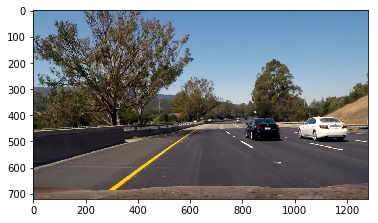

In [300]:
plt.imshow(draw_img)
plt.show()

In [301]:
from utils import feature_extraction; reload(feature_extraction)

bbox_list = feature_extraction.find_cars(
    test_img_rgb, convert_to,
    y_start,  y_stop, scale,
    clf, scaler,
    orientations=orientations, 
    pixels_per_cell=pixels_per_cell, 
    cells_per_block=cells_per_block
)

img_drawn = feature_extraction.draw_boxes(test_img_rgb, bbox_list)

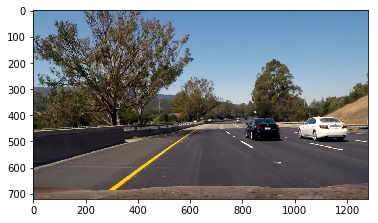

In [281]:
plt.imshow(img_drawn)
plt.show()

In [49]:
# heatmap
from utils import vehicle_detection; reload(vehicle_detection)

heatmap = np.zeros_like(test_img_rgb[:, :, 0]).astype(np.float)
heatmap = vehicle_detection.add_heat(heatmap, bbox_list)
heatmap = vehicle_detection.apply_threshold(heatmap, 1)

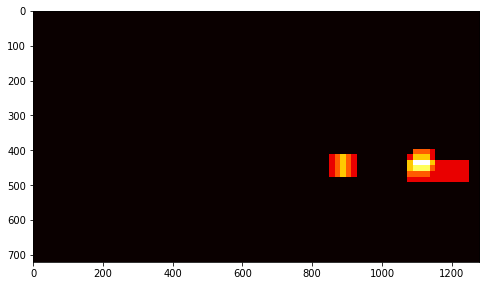

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.imshow(np.clip(heatmap, 0, 255), cmap='hot')
plt.show()

In [51]:
# labeled bbox
from scipy.ndimage.measurements import label

from utils import vehicle_detection; reload(vehicle_detection)

labels = label(heatmap)
bbox = vehicle_detection.get_labeled_bboxes(test_img_rgb, labels)
img_detected = cv2.rectangle(img_drawn, bbox[0], bbox[1], (0, 0, 255), 6)

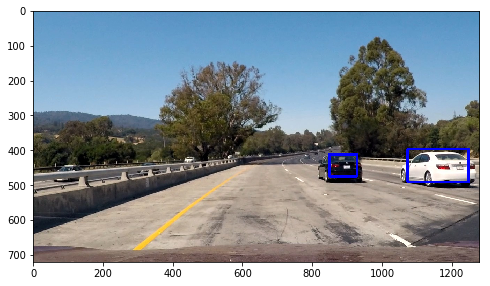

In [52]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax1.imshow(img_detected)
plt.show()

### pipeline test

In [82]:
from scipy.ndimage.measurements import label

from utils import vehicle_detection
reload(vehicle_detection)


def pipeline(img):
    bboxes = []
    
    # Find bboxes
    bbox_list = vehicle_detection.find_cars(
        img, y_start=300,  y_stop=550,
        classifier=clf, X_scaler=scaler,
        orientations=12)
    # Heatmap
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    heatmap = vehicle_detection.add_heat(heatmap, bbox_list)
    heatmap = vehicle_detection.apply_threshold(heatmap, 1)
    # Labeled bbox
    labels = label(heatmap)
    bboxes = vehicle_detection.get_labeled_bboxes(img, labels)
    img_detected = vehicle_detection.draw_boxes(img, bboxes)

    return img_detected

In [104]:
from scipy.ndimage.measurements import label

from utils import vehicle_detection
reload(vehicle_detection)


def pipeline_for_video(img):
    # Find bboxes
    bbox_list = vehicle_detection.find_cars(
        img, y_start=300,  y_stop=550,
        classifier=clf, X_scaler=scaler,
        orientations=12)
    # Heatmap
    heatmap = np.zeros_like(img[:, :, 0]).astype(np.float)
    heatmap = vehicle_detection.add_heat(heatmap, bbox_list)
    heatmap = vehicle_detection.apply_threshold(heatmap, 1)
    # Labeled bbox
    labels = label(heatmap)
    bboxes = vehicle_detection.get_labeled_bboxes(img, labels)
    bboxes_list.extend(bboxes)

    last_several_bboxes = bboxes_list[-10:]
    heatmap_avg = np.zeros_like(img[:, :, 0]).astype(np.float)
    heatmap_avg = vehicle_detection.add_heat(heatmap_avg, last_several_bboxes)
    heatmap_avg = vehicle_detection.apply_threshold(heatmap_avg, 5)
    labels = label(heatmap_avg)
    bboxes_avg = vehicle_detection.get_labeled_bboxes(img, labels)
    img_detected = vehicle_detection.draw_boxes(img, bboxes_avg)
    
    return img_detected

In [54]:
img_files = glob.glob(os.path.join('test_images', '*.jpg'))
imgs = []
for img_file in img_files:
    img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
    imgs.append(img)

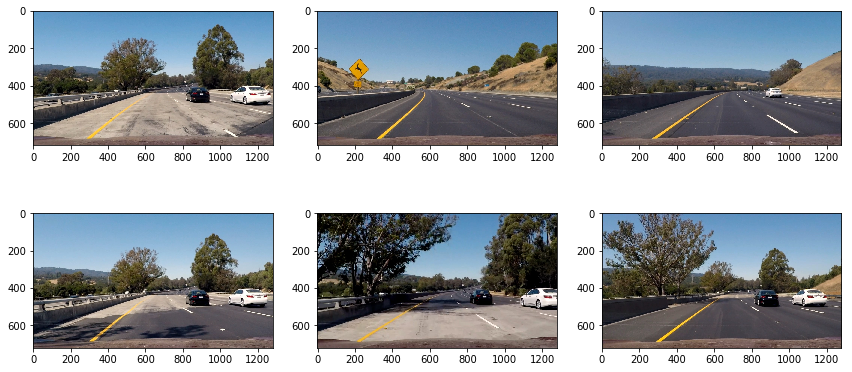

In [42]:
# test images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

axes[0][0].imshow(imgs[0])
axes[0][1].imshow(imgs[1])
axes[0][2].imshow(imgs[2])
axes[1][0].imshow(imgs[3])
axes[1][1].imshow(imgs[4])
axes[1][2].imshow(imgs[5])
plt.tight_layout()
plt.show()

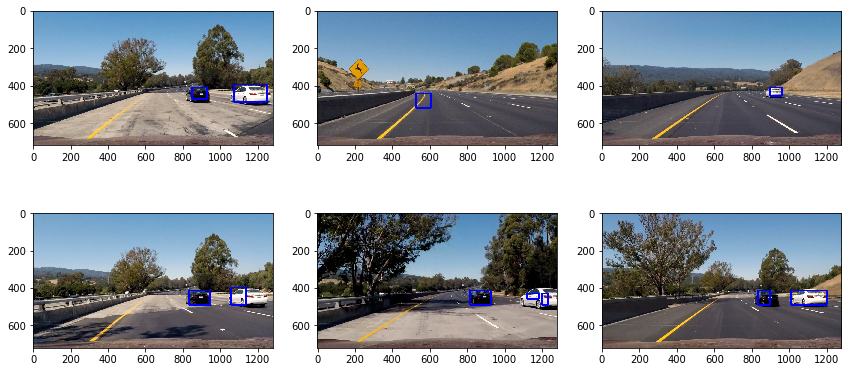

In [84]:
# Cars detected
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes[0][0].imshow(pipeline(imgs[0]))
axes[0][1].imshow(pipeline(imgs[1]))
axes[0][2].imshow(pipeline(imgs[2]))
axes[1][0].imshow(pipeline(imgs[3]))
axes[1][1].imshow(pipeline(imgs[4]))
axes[1][2].imshow(pipeline(imgs[5]))
plt.tight_layout()
plt.savefig(os.path.join('output_images', 'window_search_2_test1to6.jpg'))
plt.show()

In [98]:
# Video test
from IPython.display import HTML
from moviepy.editor import VideoFileClip

bboxes_list = []

output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(pipeline_for_video)
%time clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 15.6 s, sys: 777 ms, total: 16.4 s
Wall time: 18.4 s


### Video implementation

In [105]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip

bboxes_list = []

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline_for_video)
%time clip.write_videofile(output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [09:31<00:00,  2.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 45s, sys: 27 s, total: 9min 12s
Wall time: 9min 33s
